In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langgraph.graph import START, END, StateGraph, MessagesState
from Index_Builder_Langchain import smart_index_loader
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage

/Users/rahul/Documents/Project/ShoeLlama/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = os.path.abspath("Data")
VECTOR_STORE_DIR = os.path.abspath("faiss_index")

index= smart_index_loader(DATA_DIR, VECTOR_STORE_DIR)

retriever= index.as_retriever(similarity_top_k=3)

No Data Change Detected -- Loading Existing Vector Index...


# State Definition

In [3]:
from typing import TypedDict, List

class AgentState(TypedDict):
    question: str
    documents: List[str]
    answer: str
    needs_retrival: bool

# ----Loading LLM----

In [4]:
from langchain_openai import ChatOpenAI

api_key= os.getenv("AIMLAPI_KEY")
model= os.getenv("RAG_MODEL")

llm_model= ChatOpenAI(
    model=model,
    api_key= api_key,
    max_tokens= 512,
    temperature= 0,
    max_retries=2,
    openai_api_base= "https://api.aimlapi.com"
)

# Agent Functions

In [5]:
def decide_retrieval(state: AgentState) -> AgentState:
    
    question = state["question"]

    product_search_keywords = ["looking for", "searching for", "find", "show me", "recommend", "suggest", "available", "in stock", "new arrivals", "latest", "collection", "catalog", "browse", "options", "similar to"]
    product_detail_keywords = ["details on", "information about", "specs", "features", "material", "size guide", "fit", "color options", "price", "cost", "reviews", "rating"]
    brand_info_keywords = ["about the brand", "company", "history", "sustainability", "technology", "manufacturing", "where are they made", "brand story"]
    policy_support_keywords = ["return policy", "refund", "exchange", "shipping", "delivery time", "warranty", "track order", "cancel order"]

    all_keywords = (product_search_keywords + product_detail_keywords + brand_info_keywords + policy_support_keywords)

    needs_retrieval = any(keyword in question.lower() for keyword in all_keywords)

    return {**state, "needs_retrival": needs_retrieval}


In [6]:
def retrieve_documents(state: AgentState) -> AgentState:
    question = state["question"]
    documents = retriever.invoke(question)
    
    return {**state, "documents": documents}

In [7]:
def generate_answer(state: AgentState) -> AgentState:
    question = state["question"]
    documents = state.get("documents", [])

    if documents:
        context= "\n\n".join([doc.page_content for doc in documents])
        prompt= f"""You are a helpful assistant for an online shoe store. Use the following context to answer the question. If the documents do not contain relevant information, answer with "I don't have information about that.
Context:
{context}
Question: {question}

Answer:"""
    else:
        prompt= f"Answer the following question: {question}"

    response = llm_model.invoke(prompt)
    answer= response.content
    return {**state, "answer": answer}


In [8]:
def should_retrieve(state: AgentState) -> str:
    if state["needs_retrival"]:
        return "retrieve"
    else:
        return "generate"

# Building the Graph

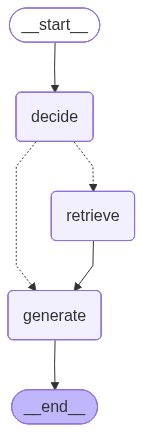

In [10]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("decide", decide_retrieval)
graph_builder.add_node("retrieve", retrieve_documents)
graph_builder.add_node("generate", generate_answer)

graph_builder.set_entry_point("decide")

graph_builder.add_conditional_edges(
    "decide",
    should_retrieve,
    {"retrieve": "retrieve",
     "generate": "generate"
     }
)
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph= graph_builder.compile()
graph

In [11]:
def ask_question(question: str):
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }

    results= graph.invoke(initial_state)
    return results

In [12]:
question1= "I am looking for running shoes. Can you recommend some options?"
response1= ask_question(question1)
response1

{'question': 'I am looking for running shoes. Can you recommend some options?',
 'documents': [Document(id='784f55a0-5ab8-4060-878b-9ac80c5a909a', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Link: https://www.nike.com/ca/t/pegasus-road-running-shoes-QgN58k/HQ2593-102'),
  Document(id='dd6fa3b5-1db2-4b05-83d2-9627c8de054b', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Link: https://www.nike.com/ca/t/run-defy-road-running-shoes-5q3M7Q/HM9594-002'),
  Document(id='1cfeb5c9-ce21-4696-9127-7946c305ce36', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Link: https://www.nike.com/ca/t/pegasus-road-running-shoes-DC1Cxh/HQ2592-600'),
  Document(id='ba39a6ca-71ba-43dc-ab90-69751e18f712', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Link: https://www.nike.com/ca/t/flex-experience-run-12-roa

In [13]:
question2= "I am looking for a comfortable walking shoe. Can you recommend some options?"
response2= ask_question(question2)
response2

{'question': 'I am looking for a comfortable walking shoe. Can you recommend some options?',
 'documents': [Document(id='1162dc79-b7da-43a3-a067-b1650813bce0', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content="Description: Considerably more comfort for long walks in sleek style comes with the D'Lux Walker black sneaker from Skechers. Soft woven athletic knit mesh and smooth synthetic upper in a stretch laced athletic comfort walking sneaker with stitching and overlay accents. Well cushioned Skech-Foam"),
  Document(id='365975fd-3b2c-45c2-92ef-ee450370fbd4', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='for an easy fitExclusive Heel Pillow holds your foot securely in placeSkechers Air-Cooled Memory Foam cushioned comfort insoleSmooth leather upper in an allover paisley print with stretch lacesFlexible traction outsole Design Elements LeatherMemory FoamLaceTractionSlip-Ins Skechers Technol

In [15]:
question3= "Can you recommend shoes for flat feet?"
response3= ask_question(question3)
response3

{'question': 'Can you recommend shoes for flat feet?',
 'documents': [Document(id='9f8fd6a9-f9eb-4195-bd36-3c6f5daff22e', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='SupportContoured FootbedCushioned InsoleSynthetic, \xa0365arch m'),
  Document(id='365975fd-3b2c-45c2-92ef-ee450370fbd4', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='for an easy fitExclusive Heel Pillow holds your foot securely in placeSkechers Air-Cooled Memory Foam cushioned comfort insoleSmooth leather upper in an allover paisley print with stretch lacesFlexible traction outsole Design Elements LeatherMemory FoamLaceTractionSlip-Ins Skechers Technology,'),
  Document(id='d46ec460-f70c-48eb-b8d5-f4833a7a4a5a', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='built with durable traction pods in heel for lightweight Cushioning & comfort,Regular,Style #: 3026039,Importe

In [16]:
question4= "I am looking for some loafers I can wear to work. Can you recommend some options?"
response4= ask_question(question4)
response4

{'question': 'I am looking for some loafers I can wear to work. Can you recommend some options?',
 'documents': [Document(id='c0c32a80-7d3b-4ff2-bf72-485637aab711', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Description: The Bradley Walk brown lace up loafers from Clarks is designed with a full grain tumbled leather upper that suits this versatile shoe to weekends and work duty. A lightweight EVA outsole makes it durable. As an Ultimate Comfort style, it features a moisture-wicking Ortholite footbed'),
  Document(id='1cd6ff87-a359-4e6c-904e-3a9f46f0df11', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Name: Sorel Joan Now City Loafer Women\nPrice: $169.99'),
  Document(id='e017dc35-0f9c-4bb3-b30c-fe28f07a6c54', metadata={'source': '/Users/rahul/Documents/Project/ShoeLlama/Data/Shoe_Data.csv'}, page_content='Link: https://www.softmoc.com/ca/i/clarks/mens/shoes/mns-bradley-step-casua